# Descriptive statistics of Wada test results

### import modules

In [1]:
import pandas as pd
import numpy as np

from sklearn import cluster

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set_context('poster')

%matplotlib inline

### get data

In [2]:
df = pd.read_csv('../data/raw/csv/wadaData.csv', index_col=[0])

In [3]:
df.shape

(65, 9)

### set color scheme

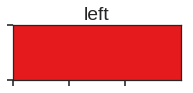

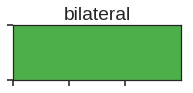

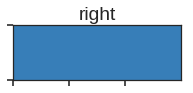

In [4]:
my_palette = sns.color_palette('Set1', 3)

color_dict = {
    'left': my_palette[0],
    'bilateral': my_palette[2],
    'right': my_palette[1]
}

for c in color_dict.keys()[::-1]:
    sns.palplot(color_dict[c])
    plt.title(c)

### get results of 2-sided Wada

In [5]:
df_2sided_wada = df.loc[:, ['wada', 'score']][df.loc[:, 'two'] == 1]
df_2sided_wada.loc[:, 'score'] = pd.to_numeric(df_2sided_wada.loc[:, 'score'])

In [6]:
df_2sided_wada.shape

(44, 2)

In [ ]:
df_2sided_wada.tail()

### cluster analysis

Initialize: Try to find 3 clusters in the data

In [8]:
clf = cluster.KMeans(n_clusters=3)

Fit: cluster the bialteral Wada scores

In [9]:
df_2sided_wada.loc[:, 'k'] = clf.fit_predict(df_2sided_wada.loc[:, ['score']])

In [ ]:
df_2sided_wada.tail()

Check if automatic clustering is in accordance with clinical evaluation. If this is the case, each clinical group should be represented by one number - and by a unique number.

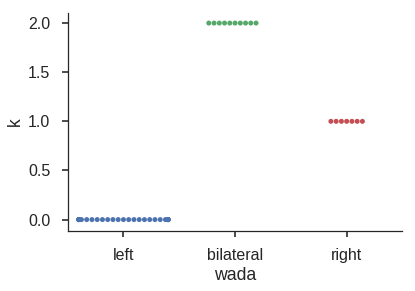

In [11]:
sns.swarmplot(data=df_2sided_wada, x='wada', y='k')
sns.despine()
plt.show()

### plot a histogram

In [12]:
def make_hist_plot(this_df):

    # Assign cluster numbers to clinical labels
    k_dict = this_df.groupby('wada').first()['k'].to_dict()

    # loop through the labels (in a hard-coded order)
    for k in ['left', 'bilateral', 'right']:
        if k in this_df.loc[:,'wada'].values:
            # get all patients from a clinical group/cluster
            is_k = (this_df.loc[:, 'k'] == k_dict[k])

            # get scores from these patients
            x = this_df.loc[:, 'score'][is_k]

            # hack in case we only have one value in a group
            if x.shape[0]<2:
                print x.shape[0],x
                x.loc['dummy'] = -999

            # make histogram
            sns.distplot(
                x,
                #alpha=0.8,
                bins=np.linspace(-1, 1, 21),
                kde=False,
                color=color_dict[k],
                rug=True,
                rug_kws={
                    "alpha": 0.3,
                    "linewidth": 2
                },
                label=k)

    sns.despine(offset=5, trim=True)

    return

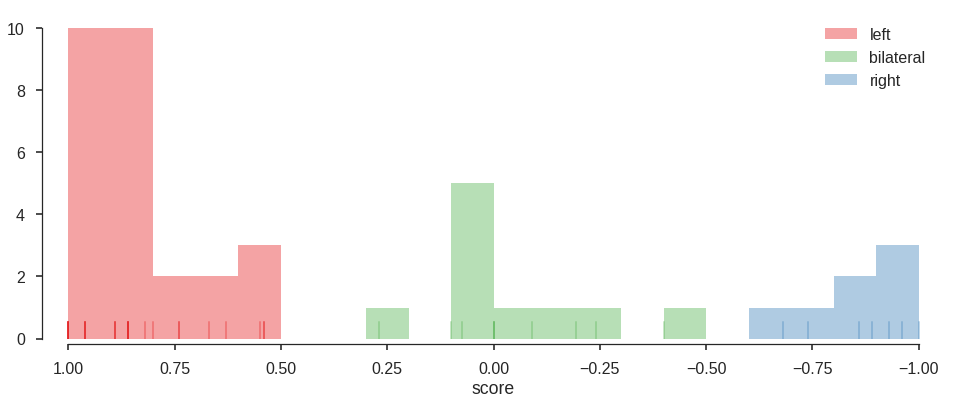

In [13]:
fig = plt.figure(figsize=(16, 6))
make_hist_plot(df_2sided_wada)
plt.legend()
plt.xlim(1.05, -1.05, -0.1)
plt.show()

### get results of 1-sided Wada

In [14]:
df_1sided_wada = df.loc[:, ['wada', 'score', 'injection']][
    df.loc[:, 'one'] == 1]

In [15]:
df_1sided_wada.shape

(21, 3)

In [ ]:
df_1sided_wada.tail()

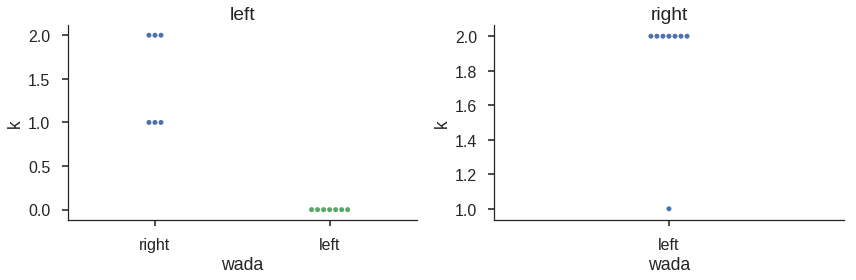

In [17]:
df_1sided_wada.loc[:, 'k'] = clf.fit_predict(df_1sided_wada.loc[:, ['score']])

fig = plt.figure(figsize=(12, 4))

for n, g in enumerate(['left', 'right']):

    injection_side = (df_1sided_wada.loc[:, 'injection'] == g)
    this_df = df_1sided_wada[injection_side]
    k_dict = this_df.groupby('wada').first()['k'].to_dict()
    ax = plt.subplot(1, 2, n + 1)
    sns.swarmplot(data=this_df, x='wada', y='k', ax=ax)
    sns.despine()
    ax.set_title(g)
plt.tight_layout()
plt.show()

### remove problem cases

In [18]:
df_1sided_wada_clean = df_1sided_wada[(
    (df_1sided_wada.loc[:, 'score'] > 0.) &
    (df_1sided_wada.loc[:, 'score'] < 0.2)) == False]

In [19]:
df_1sided_wada_clean.shape

(18, 4)

/data/martin/frontSub/venv/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


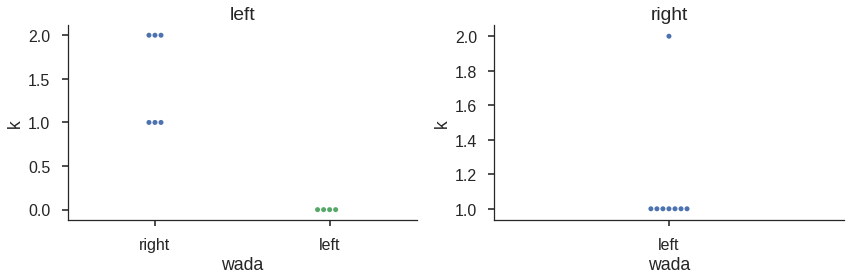

In [20]:
df_1sided_wada_clean.loc[:, 'k'] = clf.fit_predict(df_1sided_wada_clean.loc[:, ['score']])

fig = plt.figure(figsize=(12, 4))

for n, g in enumerate(['left', 'right']):

    injection_side = (df_1sided_wada_clean.loc[:, 'injection'] == g)
    this_df = df_1sided_wada_clean[injection_side]
    k_dict = this_df.groupby('wada').first()['k'].to_dict()
    ax = plt.subplot(1, 2, n + 1)
    sns.swarmplot(data=this_df, x='wada', y='k', ax=ax)
    sns.despine()
    ax.set_title(g)
plt.tight_layout()
plt.show()

### store data for later re-use

In [22]:
df_wada_clean = pd.concat([df_2sided_wada,df_1sided_wada_clean])
df_wada_clean.to_csv('../data/processed/csv/wada_clean.csv')

In [ ]:
df_wada_clean

In [24]:
df_wada_clean.shape

(62, 4)

some stats:

In [25]:
print 'number of patients:',np.unique(df.index).shape[0]
print 'number of bilateral tests', df_2sided_wada.shape[0]
print 'number of unilateral tests', df_1sided_wada.shape[0]

print 'number of unilateral dropped:',df_1sided_wada.shape[0]-df_1sided_wada_clean.shape[0]

number of patients: 65
number of bilateral tests 44
number of unilateral tests 21
number of unilateral dropped: 3


Distribution of lateralisation

In [26]:
lat_df = df_wada_clean.groupby('wada').count().loc[:,['score']]
lat_df

,score
wada,
bilateral,10
left,39
right,13


In [27]:
lat_perc_df = lat_df/lat_df.sum(axis=0) * 100
lat_perc_df.round(0)

,score
wada,
bilateral,16.0
left,63.0
right,21.0


Distribution of injection site (0= bilateral Wada test)

In [28]:
df_wada_clean.fillna(0).groupby('injection').count()

,k,score,wada
injection,,,
0,44,44,44
left,10,10,10
right,8,8,8


### show clean data

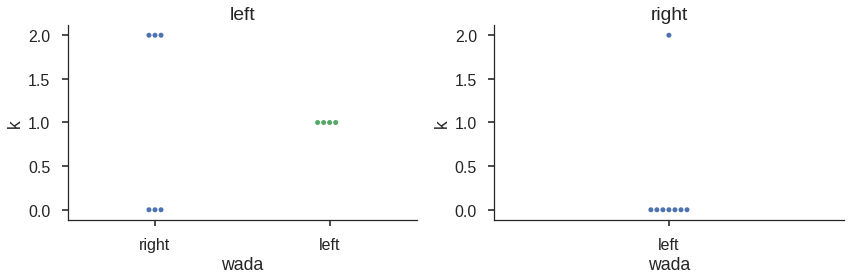

In [29]:
df_1sided_wada_clean.loc[:, 'k'] = clf.fit_predict(
    df_1sided_wada_clean.loc[:, ['score']])

fig = plt.figure(figsize=(12, 4))

for n, g in enumerate(['left', 'right']):

    injection_side = (df_1sided_wada_clean.loc[:, 'injection'] == g)
    this_df = df_1sided_wada_clean[injection_side]
    k_dict = this_df.groupby('wada').first()['k'].to_dict()
    ax = plt.subplot(1, 2, n + 1)
    sns.swarmplot(data=this_df, x='wada', y='k', ax=ax)
    sns.despine()
    ax.set_title(g)

plt.tight_layout()
plt.show()

In [30]:
is_left = df_1sided_wada_clean.loc[:, 'injection'] == 'left'
is_right = (is_left == False)

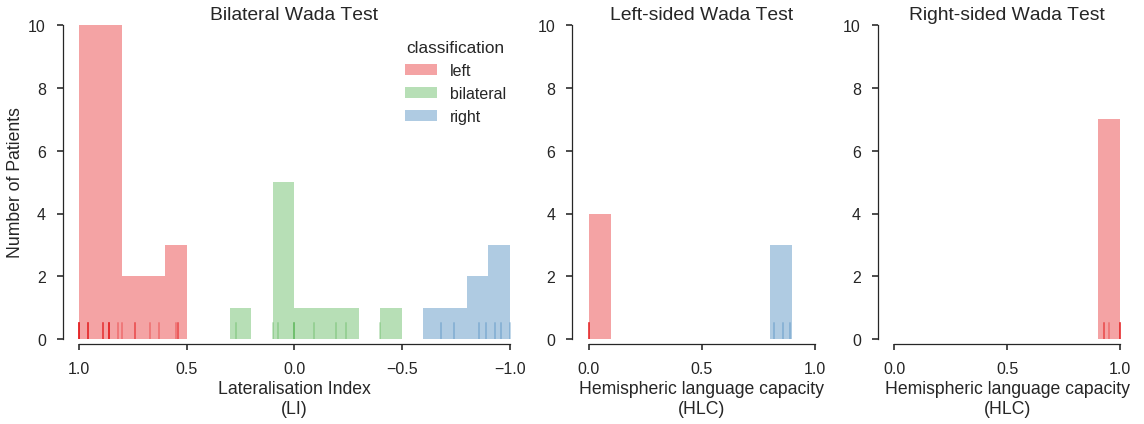

In [31]:
fig = plt.figure(figsize=(16, 6))

plt.subplot2grid((1, 11), (0, 0), colspan=5)

plt.ylim(0, 10)
plt.xlim(1.05, -1.05, -0.1)
plt.xticks(np.linspace(-1, 1, 5))
make_hist_plot(df_2sided_wada)
plt.xlabel('Lateralisation Index\n(LI)')
plt.ylabel('Number of Patients')
legend = plt.legend(title='classification')
plt.setp(legend.get_title(), fontsize='xx-large')
plt.title('Bilateral Wada Test')

plt.subplot2grid((1, 11), (0, 5), colspan=3)
plt.xlim(-0.05, 1.05)
plt.xticks(np.linspace(0, 1, 3))
plt.ylim(0, 10)
make_hist_plot(df_1sided_wada_clean[is_left])
plt.xlabel('Hemispheric language capacity\n(HLC)')
plt.title('Left-sided Wada Test')

plt.subplot2grid((1, 11), (0, 8), colspan=3)
plt.xlim(-0.05, 1.05)
plt.xticks(np.linspace(0, 1, 3))
plt.ylim(0, 10)
make_hist_plot(df_1sided_wada_clean[is_right])
plt.xlabel('Hemispheric language capacity\n(HLC)')
plt.title('Right-sided Wada Test')

#plt.suptitle('Distribution of Wada Scores', y=1.08, fontsize=24)
plt.tight_layout()
plt.savefig(
    '../reports/figures/02-wada-score-distribution.png',
    bbox_inches='tight',
    dpi=300)
plt.show()

Combined histogram (bars) and rug plot (lines). The histograms have 0.1-sized bins, while the rug plot has zero-sized bins. Stronger color of rug plot lines indicate overlapping values, as reflected in higher bars of the histogram. 
Colors denote the clinical classification of the data, which is identical to the results of an unsupervised clustering algorithm.